In [52]:
using CSV, DataFrames, DataFramesMeta, Missings
using StatsBase, Statistics, MatrixLM
using Random, Distributions, StatsModels
using LinearAlgebra
using FreqTables, Plots, StatsPlots

In [53]:
begin
	######################
	# External functions #
	######################
	include(joinpath(@__DIR__, "..", "src","mLinearModel.jl" ));
	include(joinpath(@__DIR__,"..", "src","myPlots.jl" ));

end;

slctFishOil = "true"  # set value of fish oil supplementation

"true"

In [54]:
#############
# Load data #
#############

# Load look up table for lipids
LipidsXref = realpath((@__DIR__)*"/../data/data_processed/inl2b_Lipids_Xref.csv")
dfLipidsXref = DataFrame(CSV.File(LipidsXref));

# Load data set
fileLipids = realpath((@__DIR__)*"/../data/data_processed/inl2b_Lipids.csv")
dfLipids = DataFrame(CSV.File(fileLipids));

################
# Filter cases #
################
# true => unpaired
# false => paired (rechallenge)
isunpairFlag = true;
df = getCases(dfLipids, isunpaired = isunpairFlag);

# Check to filter none fish oil users 
hasFishOil = eval(Meta.parse(slctFishOil));

if !hasFishOil
    # Get only individuals with no fish oil
    filter!(row-> row.FishOil == "no" ,df);
end


# standardize lipids mass-to-charge ratio
funStandardize!(df, isunpaired = isunpairFlag);

In [55]:
begin
	########################
	# Load Z raw all valid #
	########################

	# Get Zmat
	dfZrawAll =  DataFrame(CSV.File("../data/data_processed/ZmatRawAll.csv"))

	classLipids = freqtable(dfZrawAll.Class)
	DataFrame(Class = names(classLipids, 1), Count = collect(classLipids[:]))

end

Row,Class,Count
,String,Int64
1,Ceramide 1-phosphates [SP0205],11
2,Ceramide phosphocholines (sphingomyelins) [SP0301],158
3,Ceramides [SP02],93
4,Cholesterol and derivatives [ST0101],1
5,Diacylglycerols [GL0201],45
6,Dimethylphosphatidylethanolamine,15
7,Fatty acyl carnitines [FA0707],25
8,Glycerophosphates [GP10],53
9,Glycerophosphocholines [GP01],410


In [56]:
begin
	#######################
	# Plotting attributes #
	#######################
	myfont = "Helvetica"
	mytitlefontsize = 12
end;

# Pluto UI widgets values

slctFishOil = "true"  
rdZ = "Triglycerides"
rdX = "false"

"false"

In [57]:
begin
	# Get Zmat
	fZrawAll = "../data/data_processed/ZmatRawAll.csv"
	fZrawTG = "../data/data_processed/ZmatRawTG.csv"
	fZrawP = "../data/data_processed/ZmatRawPhos.csv"
	fZrawPC = "../data/data_processed/ZmatRawPhosPC.csv"
	# fZrawPE = "../../data/dataprocessed/ZmatRawPhosPE.csv"

	fZraw = Dict("All"=> fZrawAll,
				 "Triglycerides"=> fZrawTG,
				 "Phospholipids"=> fZrawP,
				 "Phospholipids: PC"=> fZrawPC);

	dfZraw =  DataFrame(CSV.File(fZraw[rdZ]))
	dfZraw = dfZraw[findall(x -> [x] ⊆ names(df), dfZraw.lipID),:]

	m =  length(dfZraw.lipID); #ifelse(isunpairFlag, size(df)[2]-5, size(df)[2]-2)

	is4ways = eval(Meta.parse(rdX));

	# ZI is identity matrix
	ZI = convert(Array{Float64, }, collect(I(m)));
	CoefZI, CIZI, TstatZI, varZI = getCoefs(df, ZI, responseSelection = dfZraw.lipID,
									 isunpaired = isunpairFlag,
									 hasFishOil = hasFishOil,
									 is4ways = is4ways);


	# Get X and Y
	if hasFishOil
		if is4ways
			X, Y = getXY4ways(df, responseSelection = dfZraw.lipID,
					 isunpaired = isunpairFlag);
			covarSelection = ["1"=> "CN-No Fish Oil (intercept)", "2"=> "CN-Fish Oil",
						  "3"=> "CS-No Fish Oil", "4"=> "CS-Fish Oil"]
		else
			X, Y = getXY(df, responseSelection = dfZraw.lipID,
					 isunpaired = isunpairFlag);
			covarSelection = ["1"=> "Intercept", "2"=> "SAMS status",
						  "3"=> "Fish Oil", "4"=> "Interaction SAMS-Fish Oil"]
		end
	else
		X, Y = getXYnoFishOil(df, responseSelection = dfZraw.lipID,
					 isunpaired = isunpairFlag);
		covarSelection = ["1"=> "Intercept", "2"=> "SAMS status"]
	end

	# nameX contains labels for plotting
	if isunpairFlag
		if is4ways
			namesX = ["CN-No Fish Oil" "CN-Fish Oil" "CS-No Fish Oil" "CS-Fish Oil"]
		else
    		namesX = ["Intercept" "SAMS status" "Fish Oil" "Interaction SAMS-Fish Oil"]
		end
	else
    	namesX = ["Intercept" "Interaction SAMS-Fish Oil"]
	end;
end;

In [58]:
# Two way frequency table Fish Oil vs Group

begin
	xTable = freqtable(df[:, [:FishOil, :Group]], :FishOil, :Group)
	matXfreq = collect(xTable[:,:]);
	matXfreq = vcat(matXfreq, sum(matXfreq, dims= 1))
	matXfreq = hcat(matXfreq, sum(matXfreq, dims= 2))
	dfFreqX = DataFrame(matXfreq, :auto)
	rename!(dfFreqX, Symbol.(vcat(names(xTable,2), "Total")))
	insertcols!(dfFreqX, 1, :_ => vcat("Fish Oil: ".*(names(xTable,1)), Symbol("Total")))
end

Row,_,CN,CS,Total
,Any,Int64,Int64,Int64
1,Fish Oil: no,39,26,65
2,Fish Oil: yes,15,18,33
3,Total,54,44,98


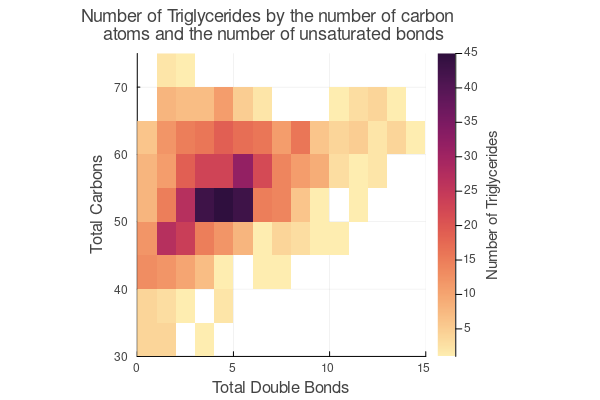

In [63]:
histogram2d(dfZraw.Total_DB, dfZraw.Total_C,
			c= :matter, aspectratio = 0.35, xlim = [0,15],
			colorbar_title = "Number of Triglycerides",
			xlabel= "Total Double Bonds", ylabel =  "Total Carbons",
			title = string("Number of ", rdZ, " by the number of carbon \n atoms and the number of unsaturated bonds \n"),
			fontfamily = myfont,
			titlefontsize = 12,
)

In [64]:
# Pluto UI widgets values

slct1 = "3" # set an initial value here
idxColXmat = parse(Int64,slct1);

In [67]:
# Pluto UI widgets values
slct2 = "factor(Total DB)" # set an initial value here

"factor(Total DB)"

In [68]:
begin
	dfZlinear = DataFrame(Total_C = dfZraw.Total_C,
				Total_DB = dfZraw.Total_DB,
                Interaction = dfZraw.Total_C.*dfZraw.Total_DB);

	# dfZtcdb = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
	#             # TotalC_0_45 = dfZraw.Total_C .< 40,
	# 			TotalC_45_55 = ((dfZraw.Total_C .>= 45) .& (dfZraw.Total_C .< 55))*1,
	# 			TotalC_55_65 = ((dfZraw.Total_C .>= 55) .& (dfZraw.Total_C .< 65))*1,
	# 			TotalC_65 = (dfZraw.Total_C .>= 65)*1,
	#             # TotalDB_0_3 = dfZraw.Total_DB .< 3,
	# 			TotalDB_3_6 = ((dfZraw.Total_DB .>= 3) .& (dfZraw.Total_DB .< 6))*1,
	# 			TotalDB_6_9 = ((dfZraw.Total_DB .>= 6) .& (dfZraw.Total_DB .< 9))*1,
	# 			TotalDB_9 = (dfZraw.Total_DB .>= 9)*1	);

	dfZtcdb = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
	            # TotalC_0_45 = dfZraw.Total_C .< 40,
	            TotalC_40_45 = ((dfZraw.Total_C .>= 40) .& (dfZraw.Total_C .< 45))*1,
	            TotalC_45_50 = ((dfZraw.Total_C .>= 45) .& (dfZraw.Total_C .< 50))*1,
	            TotalC_50_55 = ((dfZraw.Total_C .>= 50) .& (dfZraw.Total_C .< 55))*1,
	            TotalC_55_60 = ((dfZraw.Total_C .>= 55) .& (dfZraw.Total_C .< 60))*1,
	            TotalC_60_65 = ((dfZraw.Total_C .>= 60) .& (dfZraw.Total_C .< 65))*1,
	            TotalC_65_70 = ((dfZraw.Total_C .>= 65) .& (dfZraw.Total_C .< 70))*1,
	            TotalC_70 = (dfZraw.Total_C .>= 70)*1,
	            # TotalDB_0_3 = dfZraw.Total_DB .< 3,
	            TotalDB_3_6 = ((dfZraw.Total_DB .>= 3) .& (dfZraw.Total_DB .< 6))*1,
	            TotalDB_6_9 = ((dfZraw.Total_DB .>= 6) .& (dfZraw.Total_DB .< 9))*1,
	            TotalDB_9 = (dfZraw.Total_DB .>= 9)*1	);


	dfZtc = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
	            # TotalC_0_45 = dfZraw.Total_C .< 40,
				TotalC_40_45 = ((dfZraw.Total_C .>= 40) .& (dfZraw.Total_C .< 45))*1,
				TotalC_45_50 = ((dfZraw.Total_C .>= 45) .& (dfZraw.Total_C .< 50))*1,
				TotalC_50_55 = ((dfZraw.Total_C .>= 50) .& (dfZraw.Total_C .< 55))*1,
				TotalC_55_60 = ((dfZraw.Total_C .>= 55) .& (dfZraw.Total_C .< 60))*1,
				TotalC_60_65 = ((dfZraw.Total_C .>= 60) .& (dfZraw.Total_C .< 65))*1,
				TotalC_65_70 = ((dfZraw.Total_C .>= 65) .& (dfZraw.Total_C .< 70))*1,
				TotalC_70 = (dfZraw.Total_C .>= 70)*1  );

	# dfZdbcat = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
 #                DoubleBound_1 = (dfZraw.Total_DB .== 1)*1,
 #                DoubleBound_2 = (dfZraw.Total_DB .== 2)*1,
 #                DoubleBound_3 = (dfZraw.Total_DB .== 3)*1,
 #                DoubleBound_4 = (dfZraw.Total_DB .== 4)*1,
 #                DoubleBound_5 = (dfZraw.Total_DB .== 5)*1,
 #                DoubleBound_6 = (dfZraw.Total_DB .== 6)*1,
 #                DoubleBound_7 = (dfZraw.Total_DB .== 7)*1,
 #                DoubleBound_8 = (dfZraw.Total_DB .== 8)*1,
 #                DoubleBound_9 = (dfZraw.Total_DB .== 9)*1,
 #                MoreThan9 = (dfZraw.Total_DB .> 9)*1 );

	dfZdbcat = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
			TotalDB_3_6 = ((dfZraw.Total_DB .>= 3) .& (dfZraw.Total_DB .< 6))*1,
            TotalDB_6_9 = ((dfZraw.Total_DB .>= 6) .& (dfZraw.Total_DB .< 9))*1,
            TotalDB_9 = (dfZraw.Total_DB .>= 9)*1	);


	dfZoxy = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
                Oxidized = (dfZraw.Oxidation .== "yes").*1.0);

	dfZplsm = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
                plasmenyl = (dfZraw.Plasmalogen .== "plasmenyl")*1,
                plasmanyl = (dfZraw.Plasmalogen .== "plasmanyl")*1 );

	dfZphsph = DataFrame(PC = ones(Float64, size(dfZraw)[1]),
                PA = (occursin.(r"PA", dfZraw.Lipids))*1.0,
                PE = (occursin.(r"PE", dfZraw.Lipids))*1.0 );

	dfZppplt = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
				PC = (occursin.(r"GP01", dfZraw.Class))*1.0,
				PE = (occursin.(r"GP02", dfZraw.Class))*1.0,
				PA = (occursin.(r"GP10", dfZraw.Class))*1.0,
				LPC = (occursin.(r"GP0105", dfZraw.Class))*1.0,
				TG = (occursin.(r"GL0301", dfZraw.Class))*1.0);

	dfZplt = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
				Phospho = (occursin.(r"GP01|GP02|GP10", dfZraw.Class))*1.0,
				LPC = (occursin.(r"GP0105", dfZraw.Class))*1.0,
				TG = (occursin.(r"GL0301", dfZraw.Class))*1.0);

	#########################
	# Z matrix dictionaries #
	#########################

	dfZ = Dict("~ Total C*Total DB"=>dfZlinear,
			   	"factor(Total C, Total DB)"=>dfZtcdb,
				"factor(Total C)"=>dfZtc,
				"factor(Total DB)"=>dfZdbcat,
				"factor(Oxidation)"=>dfZoxy,
				"factor(Plasmalogen)"=>dfZplsm,
				"factor(PC, PA, PE)"=>dfZphsph,
				"factor(PC, PE, PA, LPC, TG)"=>dfZppplt,
				"factor(Phospho, LPC, TG)"=>dfZplt);

	classZ = Dict("~ Total C*Total DB"=>" carbon count and degree of unsaturation",
			   	"factor(Total C, Total DB)"=>"carbon count and degree of unsaturation",
				"factor(Total C)"=>"carbon count",
				"factor(Total DB)"=>"degree of unsaturation",
				"factor(Oxidation)"=>"oxidation",
				"factor(Plasmalogen)"=>"plasmalogen",
				"factor(PC, PA, PE)"=>"phospholipids class",
				"factor(PC, PE, PA, LPC, TG)"=>"lipid class",
				"factor(Phospho, LPC, TG)"=> "Phospho, LPC, TG");


	dict_namesZ = Dict("~ Total C*Total DB"=>names(dfZlinear),
			   	"factor(Total C, Total DB)"=>
					[
						"Intercept",
						"40 ≤ Total Carbon < 45",
						"45 ≤ Total Carbon < 50",
						"50 ≤ Total Carbon < 55",
						"55 ≤ Total Carbon < 60",
						"60 ≤ Total Carbon < 65",
						"65 ≤ Total Carbon < 70",
						"Total Carbon ≥ 70",
						"3 ≤ Double Bonds < 6",
						"6 ≤ Double Bonds < 9",
						"Double Bonds ≥ 9",

					],
				"factor(Total C)"=>
					[
						"Total Carbon < 40",
						"40 ≤ Total Carbon < 45",
						"45 ≤ Total Carbon < 50",
						"50 ≤ Total Carbon < 55",
						"55 ≤ Total Carbon < 60",
						"60 ≤ Total Carbon < 65",
						"65 ≤ Total Carbon < 70",
						"Total Carbon ≥ 70",
					],
				"factor(Total DB)"=>
					[
						"Double Bonds <  3",
						"3 ≤ Double Bonds < 6",
						"6 ≤ Double Bonds < 9",
						"Double Bonds ≥ 9",
					],
				"factor(Oxidation)"=>names(dfZoxy),
				"factor(Plasmalogen)"=>names(dfZplsm),
				"factor(PC, PA, PE)"=>names(dfZphsph),
				"factor(PC, PE, PA, LPC, TG)"=>names(dfZppplt),
				"factor(Phospho, LPC, TG)"=>names(dfZplt));




	namesZ =dict_namesZ[slct2]; # names(dfZ[slct2]);
	Z = Matrix{Float64}(dfZ[slct2]);
	CoefZ, CIZ, TstatZ, varZ = getCoefs(df, Z, responseSelection = dfZraw.lipID,
								  isunpaired = isunpairFlag, hasFishOil = hasFishOil,
								  is4ways = is4ways);
end;

In [69]:
db_vals = dfZraw.Total_DB  # length = 770 (number of metabolites)

cat_DB_idx = map(db_vals) do x
    if x < 3
        1
    elseif x < 6
        2
    elseif x < 9
        3
    else
        4
    end
end

db_labels = dict_namesZ["factor(Total DB)"]
cat_DB_labels = db_labels[cat_DB_idx]

770-element Vector{String}:
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "Double Bonds <  3"
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "Double Bonds <  3"
 "Double Bonds <  3"
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "Double Bonds <  3"
 "Double Bonds <  3"
 ⋮
 "6 ≤ Double Bonds < 9"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "3 ≤ Double Bonds < 6"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds ≥ 9"
 "Double Bonds <  3"

In [70]:
slct3 = "3" # Default value
idxColXmatCI = parse(Int64,slct3);

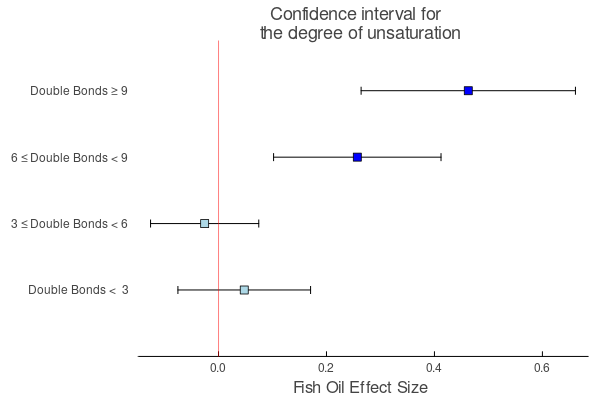

In [71]:
begin
if [slct2] ⊆ ["factor(Total C, Total DB)"]
	idx = 2

    # Carbon
    namesZtc =dict_namesZ["factor(Total C)"];

    CoefZtc, CIZtc, TstatZtc, varZtc = getCoefs(
                                        df,
                                        Matrix{Float64}(dfZ["factor(Total C)"]),
                                        responseSelection = dfZraw.lipID,
                                        isunpaired = isunpairFlag,
                                        hasFishOil = hasFishOil,
                                        is4ways = is4ways
                                        );
    # Double bonds
    namesZdb =dict_namesZ["factor(Total DB)"];

    CoefZdb, CIZdb, TstatZdb, varZdb = getCoefs(
                                        df,
                                        Matrix{Float64}(dfZ["factor(Total DB)"]),
                                        responseSelection = dfZraw.lipID,
                                        isunpaired = isunpairFlag,
                                        hasFishOil = hasFishOil,
                                        is4ways = is4ways
                                        );
    # Join results
    namesZtcdb = vcat(namesZtc[2:end], namesZdb[2:end])
    CoefZtcdb  = hcat(CoefZtc[:, 2:end] , CoefZdb[:, 2:end])
    CIZtcdb    = hcat(CIZtc[:, 2:end] , CIZdb[:, 2:end])
    TstatZtcdb = hcat(TstatZtc[:, 2:end] , TstatZdb[:, 2:end])
    varZtcdb   = hcat(varZtc[:, 2:end] , varZdb[:, 2:end])

    # p_ci_tcdb = confidenceplot(
    #                 CoefZtcdb[idxColXmatCI, :],
    #                 namesZtcdb,
    #                 CIZtcdb[idxColXmatCI, :],
    #                 xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
    #                 fontfamily = myfont,
    #                 title = string("Unadjusted") ,
    #                 titlefontsize = mytitlefontsize,
    #                 yaxis = false,
    #                 left_margin = -10mm,
    #                 # size=(800,700),
    #             )
    # p_ci_2 = confidenceplot(
    #             CoefZ[idxColXmatCI, idx:end],
    #             namesZ[idx:end],
    #             CIZ[idxColXmatCI,idx:end],
    #             xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
    #             fontfamily = myfont,
    #             title = string("Adjusted") ,
    #             titlefontsize = mytitlefontsize,
    #             right_margin = -20mm,
    #             # size=(800,700),
    # )

    p_ci_unadjusted = confidenceplot(
                    CoefZtcdb[idxColXmatCI, :],
                    namesZtcdb,
                    CIZtcdb[idxColXmatCI, :],
                    xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
                    fontfamily = myfont,
                    title = string("Unadjusted") ,
                    titlefontsize = mytitlefontsize,
                    yaxis = true,
                    right_margin = -10mm,
                    # size=(800,700),
                )
    p_ci_adjusted = confidenceplot(
                CoefZ[idxColXmatCI, idx:end],
                namesZ[idx:end],
                CIZ[idxColXmatCI,idx:end],
                xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
                fontfamily = myfont,
                title = string("Adjusted") ,
                titlefontsize = mytitlefontsize,
                yaxis = false,
                left_margin = -20mm,
                # size=(800,700),
    )


    # plot(p_ci_2, p_ci_tcdb, size = (750, 500))
    p_ua = plot(p_ci_unadjusted, p_ci_adjusted, size = (750, 500))

	# save in png
	#png(p_ua,string(
	#		    "../images/statin_mlmCI_unadjusted_",
	#		    "_",
	#		    replace(classZ[slct2], " "=> "_"),
	#		    ".png"
	#		 )
	#)

	# save in svg
    #savefig(string(
	#		    "../images/statin_mlmCI_unadjusted_",
	#		    replace(namesX[idxColXmatCI], " "=> "_"),
	#		    "_",
	#		    replace(classZ[slct2], " "=> "_"),
	#		    ".svg"
	#		)
	#)

    # plot(p_ci_2, p_ci_tcdb, size = (750, 500))
    plot(p_ci_unadjusted, p_ci_adjusted, size = (750, 500))
else
	if [slct2] ⊆ ["factor(Total C)", "factor(Total DB)"]
		idx = 1
	else
		idx = 2
	end

	p_ci = confidenceplot(
			CoefZ[idxColXmatCI, idx:end],
			namesZ[idx:end],
			CIZ[idxColXmatCI,idx:end],
			xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
			fontfamily = myfont,
			title = string("Confidence interval for \n the ", classZ[slct2]) ,
			titlefontsize = mytitlefontsize,
			# size=(800,700),
	)
	#savefig(string(
	#	"../images/statin_mlmCI_",
	#	replace(namesX[idxColXmatCI], " "=> "_"),
	#	"_",
	#	replace(classZ[slct2], " "=> "_"),
	#	".svg"))
	plot(p_ci)

end
end

In [72]:
begin
	dfCIval = DataFrame(
			Variables = namesZ[idx:end],
		    Coeffecient = round.(CoefZ[idxColXmatCI, idx:end], digits=3),
			L = round.(CoefZ[idxColXmatCI, idx:end] - CIZ[idxColXmatCI,idx:end], digits=3),
			H = round.(CoefZ[idxColXmatCI, idx:end] + CIZ[idxColXmatCI,idx:end], digits =3),
			  )
	# header = ([ "L", "H"])
	# mData = hcat(
	# 	round.(CoefZ[idxColXmatCI, idx:end] - CIZ[idxColXmatCI,idx:end], digits=3),
	# 	round.(CoefZ[idxColXmatCI, idx:end] + CIZ[idxColXmatCI,idx:end], digits =3),
	# 		)
	# DataFrames.PrettyTables.pretty_table(mData, backend = Val(:latex), header = header)

	dfCIval
end;

In [73]:
begin
	if ((slct2 == "factor(Oxidation)") | (slct2 == "factor(Plasmalogen)"))
		if slct2 == "factor(Oxidation)"
			isOxi = true
		else
			isOxi = false
		end

	dfCatego = DataFrame(Catego = ifelse(isOxi, dfZraw.Oxidation, dfZraw.Plasmalogen),
                Effect  = CoefZI[idxColXmatCI,:],
                Tstats  = TstatZI[idxColXmatCI,:]);

	@df dfCatego violin(string.(:Catego),:Effect , linewidth=0, legend = false,
    	xlabel = classZ[slct2],
		ylabel = string("Effect Size of ",namesX[idxColXmatCI]),
		grid = false,
    	title = string("Violin plot of effect size of ", namesX[idxColXmatCI],
				" \naccording to ",	classZ[slct2]," for the triglycerides"))
	end
# savefig(string("../../images/violinOxyCoef_",namesX[idxRow],".svg"))
end

In [74]:
begin
	if ((slct2 == "factor(Oxidation)") | (slct2 == "factor(Plasmalogen)"))

	@df dfCatego violin(string.(:Catego),:Tstats , linewidth=0, legend = false,
    	xlabel = classZ[slct2],
		ylabel = string("Effect Size of ",namesX[idxColXmatCI]),
		grid = false,
    	title = string("Violin plot of T-statistics of ", namesX[idxColXmatCI],
				" \naccording to ",	classZ[slct2]," for the triglycerides"))
		# savefig(string("../../images/violinOxyTstats_",namesX[idxRow],".svg"))
	end
end

In [75]:
# Gibbs Sampler for One Level Hierarchical Model

function gibbs_meta_hier_traces_db(
    b_obs::Vector{Float64},           # length m
    se_obs::Vector{Float64},          # length m
    subclass_of_met::Vector{Int},     # length m, values in 1..H (Total DB class)
    H::Int;                           # number of DB categories
    mu0::Float64 = 0.0,
    s0::Float64 = 1.0,
    halfcauchy_scale::Float64 = 1.0,
    n_iter::Int = 2000,
    burnin::Int = 500,
    thin::Int = 1,
    seed::Int = 1234,
)
    @assert length(b_obs) == length(se_obs) "b_obs and se_obs must have same length"
    @assert length(subclass_of_met) == length(b_obs) "subclass_of_met must have length m"
    @assert maximum(subclass_of_met) == H "subclass_of_met must be in 1..H"
    @assert burnin < n_iter "burnin must be < n_iter"
    @assert thin ≥ 1

    Random.seed!(seed)
    m = length(b_obs)
    lam_j = 1.0 ./ (se_obs .^ 2)  # observation precisions

    # --- initialize state ---
    theta = copy(b_obs)                                     # length m (metabolite-level effects)
    beta  = [mean(theta[subclass_of_met .== h]) for h in 1:H]  # class means
    theta0 = mean(beta)                                     # global mean over classes

    tau_w2 = 1.0   # within-class variance for theta_j | beta_h
    tau_v2 = 1.0   # between-class variance for beta_h | theta0

    lambda_w = 1.0    # IG mixture auxiliaries for half-Cauchy
    lambda_v = 1.0

    # --- precompute group indices ---
    idx_by_sub = [findall(==(h), subclass_of_met) for h in 1:H]

    # --- storage sizes ---
    n_keep = floor(Int, (n_iter - burnin) ÷ thin)

    # scalars per draw (for quick monitoring)
    draws_scalar = DataFrame(
        theta0 = Vector{Float64}(undef, n_keep),
        tau_w2 = Vector{Float64}(undef, n_keep),
        tau_v2 = Vector{Float64}(undef, n_keep),
    )

    # vectors per draw
    beta_draws  = Array{Float64}(undef, H, n_keep)   # columns = kept iters
    theta_draws = Array{Float64}(undef, m, n_keep)

    keep_idx = 0

    for it in 1:n_iter
        #######################
        # 1) update theta_j   #
        #######################
        for j in 1:m
            h = subclass_of_met[j]
            lik_prec   = lam_j[j]
            lik_sum    = lam_j[j] * b_obs[j]
            prior_prec = 1.0 / tau_w2
            prior_mean = beta[h]
            mean_th = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
            var_th  = 1.0 / (lik_prec + prior_prec)
            theta[j] = rand(Normal(mean_th, sqrt(var_th)))
        end

        #######################
        # 2) update beta_h    #
        #######################
        for h in 1:H
            J = idx_by_sub[h]
            mh = length(J)

            # likelihood: theta_j | beta_h ~ N(beta_h, tau_w2)
            lik_prec   = mh / tau_w2
            lik_sum    = (1.0 / tau_w2) * sum(theta[J])

            # prior: beta_h | theta0 ~ N(theta0, tau_v2)
            prior_prec = 1.0 / tau_v2
            prior_mean = theta0

            mean_b = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
            var_b  = 1.0 / (lik_prec + prior_prec)
            beta[h] = rand(Normal(mean_b, sqrt(var_b)))
        end

        #######################
        # 3) update theta0    #
        #######################
        # beta_h | theta0 ~ N(theta0, tau_v2)
        lik_prec   = H / tau_v2
        lik_sum    = (1.0 / tau_v2) * sum(beta)

        # prior: theta0 ~ N(mu0, s0^2)
        prior_prec = 1.0 / (s0^2)
        prior_mean = mu0

        mean_t0 = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
        var_t0  = 1.0 / (lik_prec + prior_prec)
        theta0  = rand(Normal(mean_t0, sqrt(var_t0)))

        ############################################
        # 4) update tau_w2 and tau_v2 via IG mix   #
        ############################################

        # tau_w2: within-class spread of theta_j around beta_{class(j)}
        ssw = sum((theta .- beta[subclass_of_met]).^2)
        tau_w2   = rand(InverseGamma((m + 1.0) / 2.0, 0.5 * ssw + 1.0 / lambda_w))
        lambda_w = rand(InverseGamma(1.0, 1.0 / (halfcauchy_scale^2) + 1.0 / tau_w2))

        # tau_v2: between-class spread of beta_h around theta0
        ssv = sum((beta .- theta0).^2)
        tau_v2   = rand(InverseGamma((H + 1.0) / 2.0, 0.5 * ssv + 1.0 / lambda_v))
        lambda_v = rand(InverseGamma(1.0, 1.0 / (halfcauchy_scale^2) + 1.0 / tau_v2))

        ###################################
        # 5) store post-burn (with thin) #
        ###################################
        if it > burnin && ((it - burnin) % thin == 0)
            keep_idx += 1
            draws_scalar.theta0[keep_idx] = theta0
            draws_scalar.tau_w2[keep_idx] = tau_w2
            draws_scalar.tau_v2[keep_idx] = tau_v2

            beta_draws[:, keep_idx]  .= beta
            theta_draws[:, keep_idx] .= theta
        end
    end

    return (; draws_scalar,
            beta_draws,
            theta_draws,
            last_state = (; theta0, tau_w2, tau_v2,
                          beta = copy(beta), theta = copy(theta)))
end

gibbs_meta_hier_traces_db (generic function with 1 method)

In [28]:
CoefZI

4×770 Matrix{Float64}:
  0.022235   -0.0532658   0.0481225  …   0.203894     0.169376    0.0501314
 -0.0606831   0.0316255   0.148034      -0.00550273  -0.0764164  -0.0757559
  0.060654   -0.153755    0.0648343      0.660711     0.604236    0.192638
 -0.052808    0.0385082  -0.0725604      0.0691304    0.123285    0.0308726

In [30]:
TstatZI

4×770 Matrix{Float64}:
  0.206778  -0.499205   0.455272  …   2.42619     1.92726    0.473446
 -0.564335   0.296393   1.40051      -0.0654785  -0.869513  -0.715446
  0.564064  -1.44099    0.613377      7.86198     6.87538    1.81929
 -0.491099   0.360897  -0.686471      0.822602    1.40282    0.291564

In [31]:
CIZI

4×770 Matrix{Float64}:
 0.210759  0.209134  0.207173  0.208521  …  0.164716  0.172253  0.207537
 0.210759  0.209134  0.207173  0.208521     0.164716  0.172253  0.207537
 0.210759  0.209134  0.207173  0.208521     0.164716  0.172253  0.207537
 0.210759  0.209134  0.207173  0.208521     0.164716  0.172253  0.207537

In [32]:
SeZI = CIZI/1.96

4×770 Matrix{Float64}:
 0.10753  0.106701  0.105701  0.106389  …  0.0840387  0.0878841  0.105886
 0.10753  0.106701  0.105701  0.106389     0.0840387  0.0878841  0.105886
 0.10753  0.106701  0.105701  0.106389     0.0840387  0.0878841  0.105886
 0.10753  0.106701  0.105701  0.106389     0.0840387  0.0878841  0.105886

In [33]:
k0 = 3                      # choose a covariate index
b_vec_db  = vec(CoefZI[k0, :])  # length m
se_vec_db = vec(SeZI[k0, :])
tstat_vec_db = vec(TstatZI[k0, :])

res_db = gibbs_meta_hier_traces_db(
    b_vec_db, se_vec_db, cat_DB_idx, length(unique(cat_DB_idx));
    mu0 = 0.0, s0 = 1.0,
    halfcauchy_scale = 1.0,
    n_iter = 5000, burnin = 1000, thin = 1,
    seed = 1234
)

(draws_scalar = 4000×3 DataFrame
  Row │ theta0      tau_w2     tau_v2    
      │ Float64     Float64    Float64   
──────┼──────────────────────────────────
    1 │  0.0459289  0.0227478  0.200661
    2 │  0.313359   0.019639   0.0768346
    3 │  0.345875   0.0189009  0.101232
    4 │  0.244248   0.0205803  0.166886
    5 │  0.426281   0.0234487  0.0335919
    6 │  0.271512   0.0240716  0.0526697
    7 │  0.177295   0.0230628  0.0602857
    8 │  0.216623   0.0229735  0.0387946
    9 │  0.14873    0.0203702  0.0637996
   10 │  0.142272   0.023462   0.0209618
   11 │  0.172354   0.0216303  0.0290502
  ⋮   │     ⋮           ⋮          ⋮
 3991 │  0.498129   0.0209635  0.580247
 3992 │  0.147547   0.0199819  0.168729
 3993 │  0.170539   0.0210013  0.100683
 3994 │  0.261056   0.020401   0.16849
 3995 │  0.111154   0.0221589  0.422161
 3996 │  0.583959   0.0224291  1.43746
 3997 │ -0.0916033  0.0217551  0.232629
 3998 │  0.225391   0.0215075  0.0627771
 3999 │  0.0336523  0.0234193  0.0379

In [34]:
# posterior mean and 95% CI for the parameters
function summarize_param_matrix(draws::AbstractMatrix{<:Real})
    means = mean(draws; dims=2)[:]
    std_errs = std(draws; dims=2)[:]
    lo    = mapslices(x -> quantile(x, 0.025), draws; dims=2)[:]
    hi    = mapslices(x -> quantile(x, 0.975), draws; dims=2)[:]
    return (; mean = means, std_err = std_errs, lo = lo, hi = hi)
end

function as_df_summary(xsum; names::Vector{<:Any})
    DataFrame(name = names, mean = xsum.mean, std_err = xsum.std_err, lo = xsum.lo, hi = xsum.hi)
end

as_df_summary (generic function with 1 method)

In [35]:
theta0_mean = mean(res_db.draws_scalar.theta0)
theta0_lo   = quantile(res_db.draws_scalar.theta0, 0.025)
theta0_hi   = quantile(res_db.draws_scalar.theta0, 0.975)

0.6371530703366831

In [36]:
beta_db = summarize_param_matrix(res_db.beta_draws)

(mean = [0.04812314045529296, 0.021968949762546975, 0.31465699419115467, 0.5183804508657929], std_err = [0.011304305689568158, 0.009973238533588138, 0.014780080724948998, 0.024342705961128773], lo = [0.02644129125563951, 0.0022594442785401556, 0.2860527302052282, 0.47136092006562014], hi = [0.07066555830757025, 0.04190276036013369, 0.344141818243129, 0.5658682368832899])

In [37]:
beta_df = as_df_summary(beta_db; names = ["db_cat$g" for g in 1:size(res_db.beta_draws,1)])

Row,name,mean,std_err,lo,hi
,String,Float64,Float64,Float64,Float64
1,db_cat1,0.0481231,0.0113043,0.0264413,0.0706656
2,db_cat2,0.0219689,0.00997324,0.00225944,0.0419028
3,db_cat3,0.314657,0.0147801,0.286053,0.344142
4,db_cat4,0.51838,0.0243427,0.471361,0.565868


In [38]:
thetaj_db = summarize_param_matrix(res_db.theta_draws)

(mean = [0.04709413731258995, -0.08430799508226615, 0.05804162903961681, 0.042052881457603476, 0.0718150342282282, 0.08105186959067984, 0.0931775717087824, 0.10481399196408368, 0.07572947518741514, 0.03718113232273068  …  0.107947930397856, 0.015656028277299925, -0.0508900117726333, -0.04158938519218364, 0.5374093138910894, 0.5498824770016344, 0.5910240072709868, 0.6267003087181029, 0.5805381829685544, 0.1417517864289211], std_err = [0.08703042010160701, 0.08755872523252678, 0.08819438269094727, 0.08503684981988546, 0.08508756538057985, 0.08451391112241649, 0.08368743482563533, 0.08512331304443395, 0.08573253338332495, 0.08893559217962109  …  0.0868342566420247, 0.08615806747953281, 0.0879720825338941, 0.08712340425489666, 0.07888731400728957, 0.07730992810118817, 0.07471282769754815, 0.07268303610299164, 0.07499924338193688, 0.08427175823851892], lo = [-0.1268702897082898, -0.2533617758436587, -0.11233826057092731, -0.1229894606379239, -0.09383227977962538, -0.08904183867654078, -0.07

In [39]:
thetaj_df = as_df_summary(thetaj_db; names = ["metabolite$g" for g in 1:size(res_db.theta_draws,1)])

Row,name,mean,std_err,lo,hi
,String,Float64,Float64,Float64,Float64
1,metabolite1,0.0470941,0.0870304,-0.12687,0.219629
2,metabolite2,-0.084308,0.0875587,-0.253362,0.0944795
3,metabolite3,0.0580416,0.0881944,-0.112338,0.235383
4,metabolite4,0.0420529,0.0850368,-0.122989,0.210266
5,metabolite5,0.071815,0.0850876,-0.0938323,0.24175
6,metabolite6,0.0810519,0.0845139,-0.0890418,0.249207
7,metabolite7,0.0931776,0.0836874,-0.070445,0.252681
8,metabolite8,0.104814,0.0851233,-0.0568436,0.275011
9,metabolite9,0.0757295,0.0857325,-0.0936168,0.241022


In [42]:
# Run multiple chains
n_iter   = 5000
burnin   = 1000
nchains  = 4
seeds    = 100 .+ (1:nchains)

res_super_chain = [gibbs_meta_hier_traces_db(
    b_vec_db, se_vec_db, cat_DB_idx, length(unique(cat_DB_idx));
    mu0 = 0.0, s0 = 1.0,
    halfcauchy_scale = 1.0,
    n_iter = 5000, burnin = 1000, thin = 1,
    seed = s
)
       for s in seeds]

4-element Vector{@NamedTuple{draws_scalar::DataFrame, beta_draws::Matrix{Float64}, theta_draws::Matrix{Float64}, last_state::@NamedTuple{theta0::Float64, tau_w2::Float64, tau_v2::Float64, beta::Vector{Float64}, theta::Vector{Float64}}}}:
 (draws_scalar = 4000×3 DataFrame
  Row │ theta0      tau_w2     tau_v2    
      │ Float64     Float64    Float64   
──────┼──────────────────────────────────
    1 │  0.133774   0.022917   0.050042
    2 │  0.344129   0.019557   0.067337
    3 │  0.262719   0.0215728  0.035672
    4 │  0.218588   0.0195423  0.0731056
    5 │  0.187316   0.0195453  0.0343505
    6 │  0.233624   0.0203561  0.22772
    7 │  0.185292   0.0193234  0.08917
    8 │  0.212504   0.0211258  0.0589227
    9 │  0.0509659  0.0220403  0.0655808
   10 │  0.0871705  0.0224788  0.0406317
   11 │  0.334339   0.0270272  0.0519478
  ⋮   │     ⋮           ⋮          ⋮
 3991 │  0.276166   0.0196764  0.079131
 3992 │  0.377968   0.0187425  0.276488
 3993 │ -0.0402646  0.0188813  0.0995756


In [43]:
# Make a cleaned version of res_super_chain
resSuper = [(
    theta0_draws = r.draws_scalar.theta0,   # Vector of theta0 draws
    beta_draws   = r.beta_draws,            # H × n_keep matrix
    thetaj_draws = r.theta_draws            # m × n_keep matrix
) for r in res_super_chain]

4-element Vector{@NamedTuple{theta0_draws::Vector{Float64}, beta_draws::Matrix{Float64}, thetaj_draws::Matrix{Float64}}}:
 (theta0_draws = [0.13377380683310736, 0.3441290305741777, 0.2627188681639917, 0.21858751745584826, 0.18731555064749564, 0.23362436612884882, 0.18529155939808953, 0.21250408020918646, 0.05096585842942603, 0.0871704501474639  …  0.27616581167454957, 0.3779684629428501, -0.040264616213296245, 0.1346322655303029, 0.26932564491781547, 0.3999824167706186, 0.03674936419715624, 0.15527944158471507, 0.3304861596272139, 0.068673770828986], beta_draws = [0.05932389173320882 0.0536836075627615 … 0.04633112021057083 0.05117000064383795; 0.035445311367294896 0.007234924175214789 … 0.012785301522734787 0.014709421379361015; 0.3263355576122835 0.32815987023968207 … 0.29001614246588825 0.31963137217115867; 0.5177136453980817 0.5463024744879302 … 0.5456112210127262 0.49182093353797274], thetaj_draws = [0.07680250402347977 -0.017564338342431783 … 0.04412121968029114 0.036342483860250

In [44]:
iters_kept_alpha(c) = length(resSuper[c].theta0_draws)
function alpha_chain_mat(resSuper, j::Int)
    mats = Vector{Vector{Float64}}()
    for c in 1:length(resSuper)
        Td = resSuper[c].thetaj_draws
        @assert Td !== nothing "thetaj_draws missing in chain $c"
        # Orient: either (m × iters) or (iters × m)
        if size(Td, 1) == iters_kept_alpha(c)         # it's (iters × m)
            push!(mats, vec(@view Td[:, j]))
        else                                     # assume (m × iters)
            push!(mats, vec(@view Td[j, :]))
        end
    end
    return hcat(mats...)  # (iters × chains)
end

alpha_chain_mat (generic function with 1 method)

In [45]:
function alpha_summary(resSuper, js::AbstractVector{<:Integer})
    rows = Vector{NamedTuple}()
    for j in js
        tc = alpha_chain_mat(resSuper, j)                # (iters × chains)
        draws = vec(tc)                              # stack all chains
        push!(rows, (metabolite=j,
                     mean = mean(draws),
                     std_err = std(draws),
                     lo95 = quantile(draws, 0.025),
                     hi95 = quantile(draws, 0.975)))
    end
    return DataFrame(rows)
end

alpha_summary (generic function with 1 method)

In [46]:
js_db = collect(1:length(b_vec_db))

post_df_db = alpha_summary(resSuper, js_db)
ols_df_db  = DataFrame(metabolite = js_db, mlm_est_db = b_vec_db[js_db], mlm_se_db = se_vec_db[js_db])
cmp_df_db  = innerjoin(post_df_db, ols_df_db, on=:metabolite)

Row,metabolite,mean,std_err,lo95,hi95,mlm_est_db,mlm_se_db
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0476132,0.0880765,-0.124436,0.219285,0.060654,0.10753
2,2,-0.0849455,0.0862315,-0.255105,0.0848358,-0.153755,0.106701
3,3,0.0591293,0.0853521,-0.109785,0.225809,0.0648343,0.105701
4,4,0.0421977,0.0864189,-0.127019,0.209302,0.0518839,0.106389
5,5,0.0733587,0.0860994,-0.0944807,0.241539,0.0871617,0.105424
6,6,0.0830254,0.086234,-0.0855671,0.253494,0.0985446,0.105441
7,7,0.0925274,0.0862121,-0.0786392,0.261261,0.115852,0.105336
8,8,0.10535,0.0850701,-0.0598662,0.272533,0.145409,0.105182
9,9,0.0773222,0.0858236,-0.0908513,0.245293,0.092515,0.105309


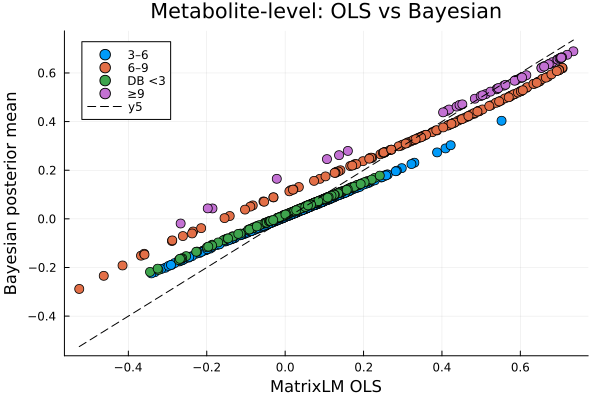

In [47]:
labels_db = ["DB <3", "3–6", "6–9", "≥9"]

scatter(cmp_df_db.mlm_est_db, cmp_df_db.mean, group = labels_db[cat_DB_idx],
        xlabel="MatrixLM OLS", ylabel="Bayesian posterior mean",
        title="Metabolite-level: OLS vs Bayesian", legend = :topleft, ms = 5)
plot!([minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
      [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)], l=:dash, c=:black)

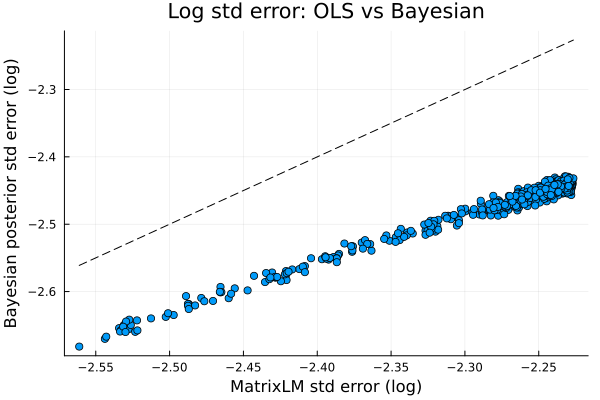

In [48]:
scatter(log.(cmp_df_db.mlm_se_db), log.(cmp_df_db.std_err),
        xlabel="MatrixLM std error (log)", ylabel="Bayesian posterior std error (log)",
        title="Log std error: OLS vs Bayesian", legend=false)
plot!([minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))],
      [minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))], l=:dash, c=:black)

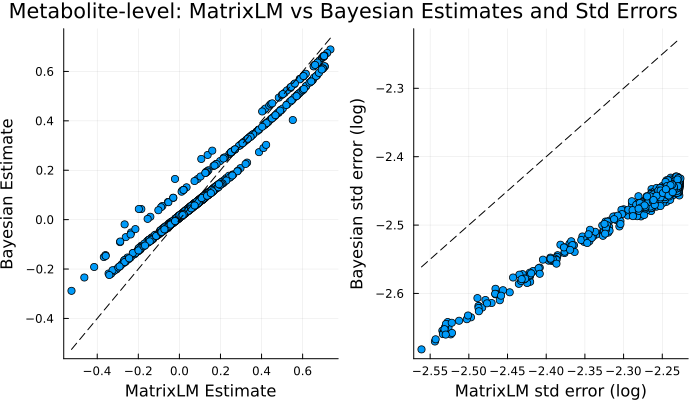

In [49]:
using Plots
gr()  

p1 = scatter(
    cmp_df_db.mlm_est_db, cmp_df_db.mean,
    xlabel = "MatrixLM Estimate",
    ylabel = "Bayesian Estimate",
    title  = "                                           Metabolite-level: MatrixLM vs Bayesian Estimates and Std Errors",
    legend = false
)
plot!(
    p1,
    [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
    [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
    l = :dash, c = :black
)

p2 = scatter(
    log.(cmp_df_db.mlm_se_db), log.(cmp_df_db.std_err),
    xlabel = "MatrixLM std error (log)",
    ylabel = "Bayesian std error (log)",
    title  = "",
    legend = false
)
plot!(
    p2,
    [minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))],
    [minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))],
    l = :dash, c = :black
)

# Combine side by side
plot(p1, p2, layout = (1, 2), size = (700, 400))

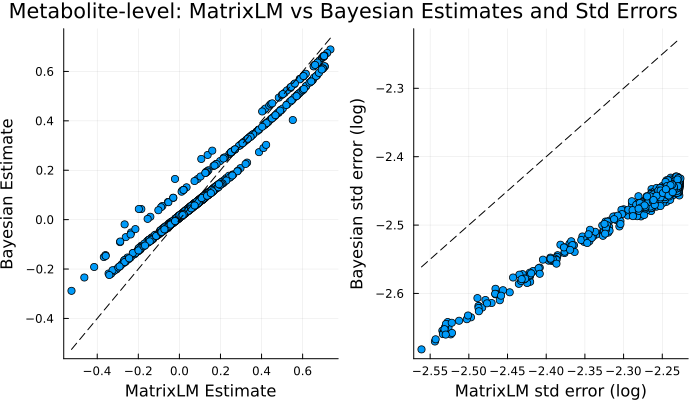

In [50]:
p = plot(p1, p2, layout = (1, 2), size = (700, 400))
#savefig(p, "matrixlm_vs_bayes_sams.pdf")

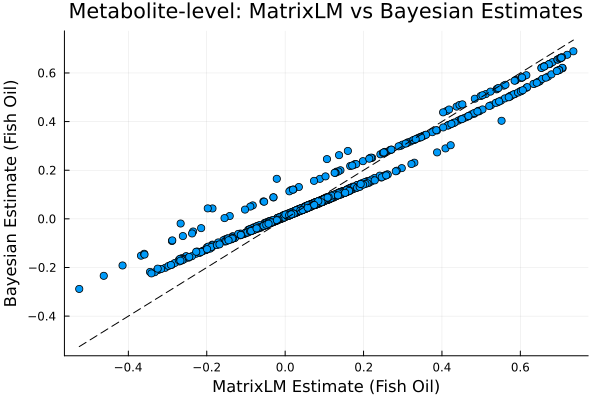

In [51]:
p3 = scatter(cmp_df_db.mlm_est_db, cmp_df_db.mean,
        xlabel="MatrixLM Estimate (Fish Oil)", ylabel="Bayesian Estimate (Fish Oil)",
        title="Metabolite-level: MatrixLM vs Bayesian Estimates", legend = false)
plot!([minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
      [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)], l=:dash, c=:black)

In [55]:
#savefig(p3, "matrixlm_vs_bayes_sams_est.pdf")

"/Users/hdubey/Library/CloudStorage/OneDrive-UniversityofTennessee/UTHSC_PostDoc/BayesHierarchy_MLM/mlm-metabolomics-supplement/SAMSstudy/interactive/matrixlm_vs_bayes_sams_est.pdf"